<a href="https://colab.research.google.com/github/Arnaldgg7/Natural_Language_Processing_RNN/blob/main/RNN_NaturalLanguageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification from scratch

This document is based on the original notebook by Mark Omernick, Francois Chollet https://keras.io/examples/nlp/text_classification_from_scratch/

## Introduction

This example shows how to do text classification starting from raw text. We demonstrate the workflow on the Tweeter Airlines sentiment
classification dataset (https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

## Setup

First of all we are going to set up our environment. Our Deep Learning framework is going to be Keras. A framework on top of TensorFlow that allows data prepocessing and Neural Networks training in a simpler way.

Our first step is fixing the random seeds for our libraries. This is not required for your experiments but helps ensuring that everytime you run this code you get the same results

In [ ]:
import tensorflow as tf
import numpy as np



from numpy.random import seed
seed(42)

from tensorflow.random import set_seed
set_seed(42)

## Load the data: US Airlines Tweets

> Bloque con sangría



Let's download the data, the data for this experiments comes from tweets about US Airlines.

In this repository you can find similar data about COVID-19 tweets in case you want to practice more these tasks: 

https://github.com/carlosep93/Text-classification-with-Keras-lab


Our data is organized as follows:

* tweets.txt: Plain text containing the tweets from the users. One tweet per line 

* labels.txt: Labels containg (Positive, Negative, Neutral), one per line in the same order as the tweets

In [ ]:
# Download Tweets
!curl -O https://raw.githubusercontent.com/carlosep93/Text-classification-with-Keras-lab/master/data/airline/tweets.txt

#Download Labels
!curl -O https://raw.githubusercontent.com/carlosep93/Text-classification-with-Keras-lab/master/data/airline/labels.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1508k  100 1508k    0     0  2115k      0 --:--:-- --:--:-- --:--:-- 2112k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125k  100  125k    0     0   283k      0 --:--:-- --:--:-- --:--:--  282k


Let's define our methods to read our raw data files into the notebook to start working with them 

In [ ]:
def read_file(file_name):
  raw_text = []
  with open(file_name,'rb') as f:
    return [str(line.strip()) for line in f.readlines()]
  

In [ ]:
tweets = read_file('tweets.txt')

labels = read_file('labels.txt')

As the data comes in a single file let's split it in Training, Validation and Test as you have seen in previos examples. To do so we are going to use SK-Learn default tool.

In [ ]:
from sklearn.model_selection import train_test_split

tweets_train, tweets_test, labels_train, labels_test = train_test_split(tweets, 
                                                                        labels, 
                                                                        test_size=0.33, 
                                                                        random_state=42)

tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(tweets_train, 
                                                                        labels_train, 
                                                                        test_size=0.33, 
                                                                        random_state=42)

# Prepare Labels

Labels come in single words, but for the network to undestand them we need them to be numeric values, and more precisely one hot vectors stating the correct class in the following form:

neutral ->  [1,0,0]
positive -> [0,1,0]
negative -> [0,0,1]


In [ ]:
label_dict = {l:i for i,l in enumerate(set(labels_train))}
print(label_dict)

{"b'negative'": 0, "b'neutral'": 1, "b'positive'": 2}


In [ ]:
def prepare_labels(split, label_dict=label_dict):
  prep_labels = []
  for label in split:
    idx = label_dict[label]
    classes = [0]*len(label_dict)
    classes[idx] = 1
    prep_labels.append(classes)
  return np.asarray(prep_labels)

In [ ]:
prep_labels_train = prepare_labels(labels_train, label_dict)
prep_labels_valid = prepare_labels(labels_valid, label_dict)
prep_labels_test = prepare_labels(labels_test, label_dict)

In [ ]:
prep_labels_train[0]

array([0, 1, 0])

# Preprocess data

Raw data has noise and ambiguities that may affect the performance of our model. Let's start by removing some of them following the steps seen during the lectures:

- Remove urls in the text
- Tokenization
- Lower casing
- Remove punctuation and stop words 
- Stemming 


In [ ]:
import re
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer

stop_words = list(stopwords.words('english')) #About 150 stopwords
stemmer = PorterStemmer()
tknzr = TweetTokenizer()

def clean_data(split):
  clean_split = []
  for sentence in split:
    #Remove urls 
    sentence = re.sub(r'http\S+', '', sentence)
    #Tokenize
    sentence = tknzr.tokenize(sentence)
    #Lower Casing & Remove Stop Words (conditional if-statements corrected, so that we now do get rid of the punctuation marks)
    sentence = [word.lower() for word in sentence 
                  if word not in stop_words 
                  and word.isalnum()]
    #Stemming
    sentence = ' '.join([stemmer.stem(word) for word in sentence])
    
    clean_split.append(sentence)

  return clean_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
clean_tweets_train = clean_data(tweets_train)
clean_tweets_valid = clean_data(tweets_valid)
clean_tweets_test = clean_data(tweets_test)

In [ ]:
clean_tweets_train[1]

'b wish everyon felt like'

# Create Vocabulary

We are going to compute the vocabulary of words that our model is able to understand. max_features defines its size. Any other word in the text will be replaced by UNK in the text.

To do so we are going to use the Keras class TextVectorization. This class does two important things for us:

- Compute the vocabulary and transform the sentences into vectors of indices. These indices are the position of each word in the vocabulary.

- Pad all sentences to the same lenght, to ensure that the model is able to create the batches without errors.

We need to represent our data in TensorFlow format. To do that we need to creat Datasets.

In [ ]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((clean_tweets_train, prep_labels_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((clean_tweets_test, prep_labels_test))
raw_valid_ds = tf.data.Dataset.from_tensor_slices((clean_tweets_valid, prep_labels_valid))

One we have our dataset we can create our TextVectorization layer. To train the vocabulary for our task we are using its method adapt only on the training data. 

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_features = 2000
sequence_length = 20
UNK = '<unk>'

vectorize_layer = TextVectorization(
    max_tokens=2000,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

## Prepare the data

We have to apply our vectorization layer to each of the sentences to have everything in the desired format of the network

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    tensor_label = tf.convert_to_tensor(label)
    tensor_label = tf.reshape(tensor_label,[1,n_labels])
    return vectorize_layer(text), tensor_label


In [ ]:
n_labels = len(label_dict)

train_ds = raw_train_ds.map(vectorize_text)
valid_ds = raw_valid_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
for batch in test_ds:
  print(batch)
  break

(<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[  2, 356,   1, 148,  30,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]])>, <tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[0, 0, 1]])>)


As it might be seen, the sentences are sequences of numbers that correspond to the indices in our vocabulary.

# Pooling Model

Having the data ready we have to create our neural network model. As you can see Keras allows us to create our models as a series of layers that get as input the output of the previous ones. In this example we are going a simple model similar to the one explained during the lectures. The model consists of three main parts:

- Embedding layer: Transforms the indices into vectors that are specific for each of the words in our vocabulary.

- Pooling: To have fixed size representations of our sentences we are going to conmpute the mean of the embeddings of all words in the sentence.

- Output Layer: From the representation of the whole sentence is computes the probability of each class. This done by applying a  dense layer with softmax activation.

Once the structure of the model is complete, we just have to compite it, and everything is ready to train.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.optimizers import Adam

embedding_dim = 100



# Text input
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
print("Embedding: ", x)
x = mean(x,axis=1)
print("Mean: ", x)

x = layers.Dropout(0.3)(x)

# We project onto a single unit output layer:
predictions = layers.Dense(n_labels, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with crossentropy loss and an adam optimizer.
opt = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Embedding:  KerasTensor(type_spec=TensorSpec(shape=(None, None, 100), dtype=tf.float32, name=None), name='embedding_7/embedding_lookup/Identity_1:0', description="created by layer 'embedding_7'")
Mean:  KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='tf.math.reduce_mean_7/Mean:0', description="created by layer 'tf.math.reduce_mean_7'")


We just have to train our model for some epochs. Take a look at the validation error to prevent the model from overfitting.

In [ ]:
epochs = 3
batch_size = 32

# Fit the model using the train and test datasets.
model.fit(train_ds,
          validation_data=valid_ds, 
          epochs=epochs, 
          batch_size=batch_size)

Epoch 1/3
6571/6571 [==============================] - 23s 3ms/step - loss: 0.8113 - accuracy: 0.6547 - val_loss: 0.5873 - val_accuracy: 0.7652
Epoch 2/3
6571/6571 [==============================] - 23s 3ms/step - loss: 0.5423 - accuracy: 0.7723 - val_loss: 0.5549 - val_accuracy: 0.7776
Epoch 3/3
6571/6571 [==============================] - 22s 3ms/step - loss: 0.4720 - accuracy: 0.8103 - val_loss: 0.5665 - val_accuracy: 0.7760


And test its performance on the test set to see how well it generates on new data.

In [ ]:
# Test it with `raw_test_ds`, which yields raw strings
model.evaluate(test_ds)

4832/4832 [==============================] - 5s 966us/step - loss: 0.5466 - accuracy: 0.7879


[0.5466060042381287, 0.7878724932670593]

## **Introduction**

Such previous Neural Network architecture is based on an **Embedding Layer** as first layer *(layer to which we provide the fixed-size vectors of integers of length '20' corresponding to all pre-processed words from each tweet that are mapped to the Word Embeddings Table)*. Recall that those tweets that didn't have 20 words were 'padded' when using the 'TextVectorization()' class in the function 'vectorize_text()' in order to be all of them made of 20 integers *(along with the label or predicted variable as a 2nd argument of the tuple)*, so that we always provide the same size of input vectors to the Neural Network. Within such layer, a mapping of integers to the Word Embeddings Table is performed, which results in 20 word vectors of '100' dimensions as output of this layer, as it is the dimension of the Word Embeddings Table.

Then, we need a '**summary vector**' as a representation of each sentence to provide to the Fully-Connected Layer to perform classifications with. To this end, a '**Mean**' along the columns (axis=1), that is, over the same vector dimensions or positions in all word vectors of each sentence, was implemented to summarise all word vectors into one single summary vector with the same length or dimensions than the dimension of the Word Embeddings Table.

Next to this summarization, a **Dropout Layer** is added, which 'cuts' or 'switch off' the transfer of the weights *(vector values from the previous summary vector)* to the next layer, so that we don't let the Neural Network to perfectly fit the data, thereby making Overfitting more difficult to happen.

Finally, a **Fully-Connected or Dense Layer** is added with as many neurons as different classes we have for classification, along with the usual 'Softmax' Activation Function to output such probabilities for each class and choose the highest one.

From now on, we are going to try to outperform the previous results, starting from the 78.79% of global Accuracy over the 3 existing classes ('Neutral', 'Positive' and 'Negative') overall.

# **1. Different values of embedding_dim.**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import pandas as pd
# Functions to output more accurate results and plot the training evolution of the Neural Network:
def print_acc(conf_mat):
    ok = conf_mat[0,0] + conf_mat[1,1] + conf_mat[2,2]
    return(ok/sum(sum(conf_mat)))

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
embedding_dim = 10



# Text input
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
print("Embedding: ", x)
x = mean(x,axis=1)
print("Mean: ", x)

x = layers.Dropout(0.3)(x)

# We project onto a single unit output layer:
predictions = layers.Dense(n_labels, activation="softmax", name="predictions")(x)

model2 = tf.keras.Model(inputs, predictions)

# Compile the model with crossentropy loss and an adam optimizer.
opt = Adam(learning_rate=0.001)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Embedding:  KerasTensor(type_spec=TensorSpec(shape=(None, None, 10), dtype=tf.float32, name=None), name='embedding_8/embedding_lookup/Identity_1:0', description="created by layer 'embedding_8'")
Mean:  KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='tf.math.reduce_mean_8/Mean:0', description="created by layer 'tf.math.reduce_mean_8'")


In [ ]:
epochs = 3
batch_size = 32

# Fit the model using the train and test datasets.
history = model2.fit(train_ds,
          validation_data=valid_ds, 
          epochs=epochs, 
          batch_size=batch_size)

Epoch 1/3
6571/6571 [==============================] - 11s 2ms/step - loss: 0.9030 - accuracy: 0.6249 - val_loss: 0.7047 - val_accuracy: 0.6929
Epoch 2/3
6571/6571 [==============================] - 10s 2ms/step - loss: 0.6701 - accuracy: 0.7182 - val_loss: 0.6263 - val_accuracy: 0.7603
Epoch 3/3
6571/6571 [==============================] - 10s 2ms/step - loss: 0.5884 - accuracy: 0.7655 - val_loss: 0.5916 - val_accuracy: 0.7714


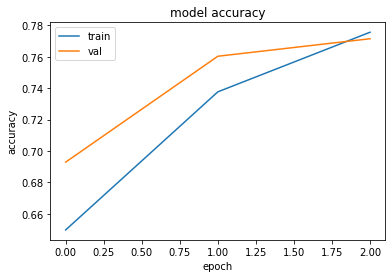

In [ ]:
plot_history(history)

In [ ]:
model2_test = model2.predict(test_ds)
labels = np.asarray(tf.concat([y for x, y in test_ds], axis=0))
model2_conf = confusion_matrix(
        labels.argmax(axis=1),
        model2_test.argmax(axis=1)
    )
print("Accuracy: " + str(round((print_acc(model2_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(model2_conf))*100,2)) + "%")
pd.DataFrame(
    model2_conf,
    index = ["Neutral", "Positive", "Negative"],
    columns = ["Neutral", "Positive", "Negative"]
)

Accuracy: 78.37%
Error: 21.63%


,Neutral,Positive,Negative
Neutral,2809,55,221
Positive,165,454,144
Negative,398,62,524


In [ ]:
print(classification_report(labels.argmax(axis=1),
                            model2_test.argmax(axis=1),
                            target_names=["Neutral", "Positive", "Negative"]))

              precision    recall  f1-score   support

     Neutral       0.83      0.91      0.87      3085
    Positive       0.80      0.60      0.68       763
    Negative       0.59      0.53      0.56       984

    accuracy                           0.78      4832
   macro avg       0.74      0.68      0.70      4832
weighted avg       0.78      0.78      0.78      4832



### **Rationale:**
As we see with the previous figures, **setting to '10' the embedding dimension resulted in worse accuracies**. If we compare the 'Accuracy' and the 'Val_Accuracy' during the training of the Neural Networks with '100' and '10' as embedding dimensions we can see the following:

*   **In the 1st epoch**, we see that in both '100' and '10' embedding dimensions, there is still Underfitting, as the '**Val_Accuracy**' is greater than '**Accuracy**', which means that the model behaves better with unseen data than with the data it is being trained with.

*   **In the 2nd epoch**, we see that things start to change. In the Neural Network with an embedding dimension of '100' the '**Accuracy**' and '**Val_Accuracy**' level off, which means that the Neural Network has tweaked the weights of all word vectors enough to be able to classify correctly both training data and unseen data. On the other hand, in the Neural Network with an embedding dimension of '10', the '**Val_Accuracy**' *(0.7603)* is still greater than the '**Accuracy**' *(0.7182)*, which entails that with just '10' weights for each word vector *(embedding dimension)* the Neural Network has not refined them enough to properly fit the training data, as just 10 weights per word means too few weights to do so with just 2 passes *(2 epochs)*.

*   **In the final 3rd epoch**, if we refer to the Neural Network with '100' as embedding dimension, we clearly see how Overfitting starts to happen, as now the '**Accuracy**' becomes higher than the '**Val_Accuracy**'. On the other hand, if we refer to the Neural Network with '10' as embedding dimension, we see that we finally achieve a relative balance between '**Accuracy**' and '**Val_Accuracy**'. It is clearly visible in the plot, where only at the end of the 2nd epoch the '**Accuracy**' surpasses the '**Val_Accuracy**'. This means that we have refined enough the 10 weights per word to start to fit the data in a proper way, generalizing equally well at this point.

The rationale provided here might be applied to the 'Loss' and 'Val_Loss' functions the Neural Network is tried to minimize, although obviously in the opposite way *(being lower values of 'Loss' with regard to 'Val_Loss' values possible Overfitting)*.

Consequently, since both Neural Networks have been trained with all same parameters except the embedding dimension, **we can draw the conclusion that the lower the embedding dimension, the more difficult it will be to perfectly fit the training data** *(and therefore avoiding Overfitting)* **but, at the same time, the more difficult it yould be for such a small value of embedding dimension to tackle more complex data and be able to generalize well**.

So, higher values of embedding dimension lead to fit the training data more quickly, as the complexity that such a Neural Network is able to deal with is high. Thus, having many weights to tweak in each batch size will lead to quickly adjust them to fit the data, as the Neural Network will have more values to 'tweak' to this end. Therefore, a relatively easy dataset to train the Neural Network with and predict based on it, will easily yield Overfitting in the initial epochs, as the Neural Network has many weights to adjust and tackle the data.

As it was aforementioned above, he opposite conclusion might be drawn as well. That is, **the lower the value of the embedding dimension, the more difficult it would be for the Neural Network to tackle very complex datasets**, since it will have too few weights to adjust in order to fit the data, so that the Neural Network will get bad performance in both training and test datasets (bad generalization error).

As a final aspect to point out, we can see that **the present dataset is not so complex to yield high differences between a Neural Network of '100' and '10' embedding dimensions (given the 3 stated epochs)**. We see that the former gets 78.79% as Test Accuracy, whereas the latter gets 78.37% as Test Accuracy with the same number of epochs and batch size. With just 2 epochs the differences would have been higher, as the Neural Network with just '10' weights per word vector as embedding dimension would not have refined enough its smaller number of weights to tweak in order to properly fit the data.

Finally, as to the **Confusion Matrix** and **Classification Report** of the Neural Network with '10' as embedding dimension, we can see that with the data we got in the stated partitions in train, validation and test, the 'Negative' tweets are the ones that entail more difficulty to predict overall, as they got the lowest F1-Score with more support than the 'Positive' tweets, for instance. Additionally, we can outline that the 'Neutral' tweets are pretty difficult to predict as well, since they hold the highest support *(more than 3 times more observations than the 2 other classes individually)*, but its F1-Score is not as high as one would expect given the number of observations the Neural Network has been trained with, especially if we refer to the Precision, which is very similar to the 'Positive' tweets.





# **2. Adding a new dense layer to the model before the prediction.**

In [ ]:
embedding_dim = 100



# Text input
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
print("Embedding: ", x)
x = mean(x,axis=1)
print("Mean: ", x)

x = layers.Dropout(0.3)(x)

# We add an additional Dense Layer:
x = layers.Dense(50, activation="tanh")(x)

# We project onto a single unit output layer:
predictions = layers.Dense(n_labels, activation="softmax", name="predictions")(x)

model3 = tf.keras.Model(inputs, predictions)

# Compile the model with crossentropy loss and an adam optimizer.
opt = Adam(learning_rate=0.001)
model3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Embedding:  KerasTensor(type_spec=TensorSpec(shape=(None, None, 100), dtype=tf.float32, name=None), name='embedding_15/embedding_lookup/Identity_1:0', description="created by layer 'embedding_15'")
Mean:  KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='tf.math.reduce_mean_15/Mean:0', description="created by layer 'tf.math.reduce_mean_15'")


In [ ]:
epochs = 3
batch_size = 32

# Fit the model using the train and test datasets.
history2 = model3.fit(train_ds,
          validation_data=valid_ds, 
          epochs=epochs, 
          batch_size=batch_size)

Epoch 1/3
6571/6571 [==============================] - 24s 4ms/step - loss: 0.7555 - accuracy: 0.6810 - val_loss: 0.5664 - val_accuracy: 0.7773
Epoch 2/3
6571/6571 [==============================] - 24s 4ms/step - loss: 0.5189 - accuracy: 0.7885 - val_loss: 0.5772 - val_accuracy: 0.7757
Epoch 3/3
6571/6571 [==============================] - 24s 4ms/step - loss: 0.4631 - accuracy: 0.8123 - val_loss: 0.6024 - val_accuracy: 0.7717


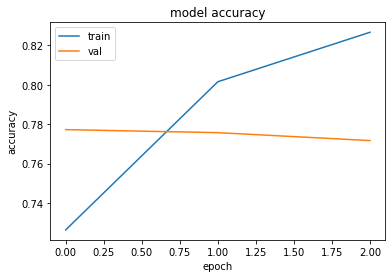

In [ ]:
plot_history(history2)

In [ ]:
model3_test = model3.predict(test_ds)
labels = np.asarray(tf.concat([y for x, y in test_ds], axis=0))
model3_conf = confusion_matrix(
        labels.argmax(axis=1),
        model3_test.argmax(axis=1)
    )
print("Accuracy: " + str(round((print_acc(model3_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(model3_conf))*100,2)) + "%")
pd.DataFrame(
    model3_conf,
    index = ["Neutral", "Positive", "Negative"],
    columns = ["Neutral", "Positive", "Negative"]
)

Accuracy: 78.04%
Error: 21.96%


,Neutral,Positive,Negative
Neutral,2780,72,233
Positive,189,496,78
Negative,414,75,495


In [ ]:
print(classification_report(labels.argmax(axis=1),
                            model3_test.argmax(axis=1),
                            target_names=["Neutral", "Positive", "Negative"]))

              precision    recall  f1-score   support

     Neutral       0.82      0.90      0.86      3085
    Positive       0.77      0.65      0.71       763
    Negative       0.61      0.50      0.55       984

    accuracy                           0.78      4832
   macro avg       0.74      0.68      0.71      4832
weighted avg       0.77      0.78      0.77      4832



### **Rationale:**
As shown by the previous results, **adding a new Dense Layer with 50 neurons and the Hyperbolic Tangent as Activation Function** *(which tends to be the most precise one, although very expensive in terms of its partial derivative when performing the Back-Propagation)* **before the final Output Layer with the Softmax didn't improve the results, quite the opposite, getting 78.04% as Global Accuracy** of the model with Test Data. In this regard, in order to be able to compare, we kept the embedding dimension in '100', as stated in our initial model, and we stated same batch size and same number of observations.

The main rationale underneath these results stems from the fact that **a new Dense Layer that process the output of our 'Summary Vector'** *(the Mean, in our case)* **is actually distorting the representation of the sentence that such a Summary Vector represents**, thereby making for the final output Dense Layer more difficult to discern just with this vector which class to predict.

In fact, we tested with 2 Dense Layers as well with 50 neurons each, instead of just 1, and the final metrics resulted even worse *(Global Accuracy of 76.80%)*. In this last case, another reason of such a poor performance would be because adding more Dense Layers entails more weights to estimate and tweak with the same amount of data, which ends up being a very complex model that is not able to properly fit the relatively small amoung of data it has available to be trained with *(perhaps adding more epochs would help, though)*.

Overall, we see in the plot that the 'Val_Accuracy' is almost flat, meaning that the generalization capability of the model remains the same, irrespective of the value of the 'Accuracy' with the Training Data. Indeed, it is likely the result of getting distorted Summary Vectors to predict, which hinders the identification of characteristics that lead to improvements in the classification and the resulting generalization error.

# **3. How does Dropout technique would affect the present Neural Network?**

In order to see the effect that the 'Dropout' layer has in a Neural Network, let's recompute the initial Neural Network architecture removing from it the Dropout Layer that was initially used in such an architecture:

## **Initial Neural Network Architecture with No Dropout Layer**

In [ ]:
embedding_dim = 100


# Text input
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
print("Embedding: ", x)
x = mean(x,axis=1)
print("Mean: ", x)

# We project onto a single unit output layer:
predictions = layers.Dense(n_labels, activation="softmax", name="predictions")(x)

model4 = tf.keras.Model(inputs, predictions)

# Compile the model with crossentropy loss and an adam optimizer.
opt = Adam(learning_rate=0.001)
model4.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Embedding:  KerasTensor(type_spec=TensorSpec(shape=(None, None, 100), dtype=tf.float32, name=None), name='embedding_16/embedding_lookup/Identity_1:0', description="created by layer 'embedding_16'")
Mean:  KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='tf.math.reduce_mean_16/Mean:0', description="created by layer 'tf.math.reduce_mean_16'")


In [ ]:
epochs = 9
batch_size = 32

# Fit the model using the train and test datasets.
history3 = model4.fit(train_ds,
          validation_data=valid_ds, 
          epochs=epochs, 
          batch_size=batch_size)

Epoch 1/9
6571/6571 [==============================] - 23s 4ms/step - loss: 0.3423 - accuracy: 0.8641 - val_loss: 0.6786 - val_accuracy: 0.7658
Epoch 2/9
6571/6571 [==============================] - 24s 4ms/step - loss: 0.3274 - accuracy: 0.8694 - val_loss: 0.7093 - val_accuracy: 0.7618
Epoch 3/9
6571/6571 [==============================] - 24s 4ms/step - loss: 0.3151 - accuracy: 0.8763 - val_loss: 0.7389 - val_accuracy: 0.7624
Epoch 4/9
6571/6571 [==============================] - 24s 4ms/step - loss: 0.3047 - accuracy: 0.8814 - val_loss: 0.7673 - val_accuracy: 0.7624
Epoch 5/9
6571/6571 [==============================] - 24s 4ms/step - loss: 0.2958 - accuracy: 0.8856 - val_loss: 0.7946 - val_accuracy: 0.7631
Epoch 6/9
6571/6571 [==============================] - 23s 4ms/step - loss: 0.2881 - accuracy: 0.8907 - val_loss: 0.8208 - val_accuracy: 0.7609
Epoch 7/9
6571/6571 [==============================] - 24s 4ms/step - loss: 0.2813 - accuracy: 0.8932 - val_loss: 0.8462 - val_accuracy:

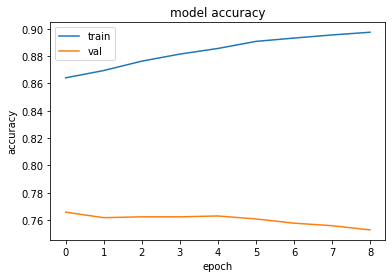

In [ ]:
plot_history(history3)

In [ ]:
model4_test = model4.predict(test_ds)
labels = np.asarray(tf.concat([y for x, y in test_ds], axis=0))
model4_conf = confusion_matrix(
        labels.argmax(axis=1),
        model4_test.argmax(axis=1)
    )
print("Accuracy: " + str(round((print_acc(model4_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(model4_conf))*100,2)) + "%")
pd.DataFrame(
    model4_conf,
    index = ["Neutral", "Positive", "Negative"],
    columns = ["Neutral", "Positive", "Negative"]
)

Accuracy: 75.89%
Error: 24.11%


,Neutral,Positive,Negative
Neutral,2679,108,298
Positive,179,476,108
Negative,374,98,512


In [ ]:
print(classification_report(labels.argmax(axis=1),
                            model4_test.argmax(axis=1),
                            target_names=["Neutral", "Positive", "Negative"]))

              precision    recall  f1-score   support

     Neutral       0.83      0.87      0.85      3085
    Positive       0.70      0.62      0.66       763
    Negative       0.56      0.52      0.54       984

    accuracy                           0.76      4832
   macro avg       0.69      0.67      0.68      4832
weighted avg       0.75      0.76      0.76      4832



**Indeed, we get much worse results when generalizing, with a Global Accuracy with the Test Data of 75.89%**. We needed to increase the number of 'epochs' for the model to see that *(we set them at '9', being 3 times the previous epochs)*, since the Neural Network architecture is not so complex with regard to the data it is dealing with, which means that it needs more epochs to fit better the data and make evident the Overfitting setting.

As we see in the plot and in the 'Accuracy' and 'Val_Accuracy' values from each epoch of the training, **already in the very first epoch the value of the 'Accuracy' (86.41%) becomes higher than the 'Val_Accuracy' (76.58%)**. Such a difference becomes higher as we get to the rest of the epochs. That is, **the model is starting to fit better and better the training dataset and starting to learn not just the Regular Structure of the data** *(which would allow the model to generalize equally well)*, **but also the noise or non-regular structure within the data and the specific characteristics that shape the training data**, which might not be present in the test data and, therefore, the 'Val_Accuracy' and the corresponding Global Accuracy with the test data become worse.

Now, we can see how different values of Dropout affect the results. We already saw a value of '0.3' of Dropout in the initial Neural Network architecture and the Global Accuracy we got with test data. Let's now see how a different value might change the resulting metrics of the model:

## **Initial Neural Network Architecture with Dropout Layer (with higher value and reposition)**

In [ ]:
embedding_dim = 100


# Text input
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
print("Embedding: ", x)

x = layers.Dropout(0.8)(x)

x = mean(x,axis=1)
print("Mean: ", x)


# We project onto a single unit output layer:
predictions = layers.Dense(n_labels, activation="softmax", name="predictions")(x)

model5 = tf.keras.Model(inputs, predictions)

# Compile the model with crossentropy loss and an adam optimizer.
opt = Adam(learning_rate=0.001)
model5.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Embedding:  KerasTensor(type_spec=TensorSpec(shape=(None, None, 100), dtype=tf.float32, name=None), name='embedding_26/embedding_lookup/Identity_1:0', description="created by layer 'embedding_26'")
Mean:  KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='tf.math.reduce_mean_26/Mean:0', description="created by layer 'tf.math.reduce_mean_26'")


In [ ]:
epochs = 6
batch_size = 32

# Fit the model using the train and test datasets.
history4 = model5.fit(train_ds,
          validation_data=valid_ds, 
          epochs=epochs, 
          batch_size=batch_size)

Epoch 1/6
6571/6571 [==============================] - 24s 4ms/step - loss: 0.8637 - accuracy: 0.6338 - val_loss: 0.6613 - val_accuracy: 0.7328
Epoch 2/6
6571/6571 [==============================] - 23s 3ms/step - loss: 0.6336 - accuracy: 0.7350 - val_loss: 0.5957 - val_accuracy: 0.7643
Epoch 3/6
6571/6571 [==============================] - 23s 4ms/step - loss: 0.5754 - accuracy: 0.7586 - val_loss: 0.5737 - val_accuracy: 0.7723
Epoch 4/6
6571/6571 [==============================] - 23s 4ms/step - loss: 0.5362 - accuracy: 0.7818 - val_loss: 0.5658 - val_accuracy: 0.7717
Epoch 5/6
6571/6571 [==============================] - 23s 4ms/step - loss: 0.5116 - accuracy: 0.7962 - val_loss: 0.5622 - val_accuracy: 0.7736
Epoch 6/6
6571/6571 [==============================] - 23s 4ms/step - loss: 0.4897 - accuracy: 0.7990 - val_loss: 0.5597 - val_accuracy: 0.7785


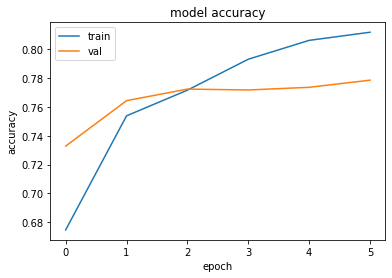

In [ ]:
plot_history(history4)

In [ ]:
model5_test = model5.predict(test_ds)
labels = np.asarray(tf.concat([y for x, y in test_ds], axis=0))
model5_conf = confusion_matrix(
        labels.argmax(axis=1),
        model5_test.argmax(axis=1)
    )
print("Accuracy: " + str(round((print_acc(model5_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(model5_conf))*100,2)) + "%")
pd.DataFrame(
    model5_conf,
    index = ["Neutral", "Positive", "Negative"],
    columns = ["Neutral", "Positive", "Negative"]
)

Accuracy: 79.41%
Error: 20.59%


,Neutral,Positive,Negative
Neutral,2762,78,245
Positive,157,503,103
Negative,354,58,572


In [ ]:
print(classification_report(labels.argmax(axis=1),
                            model5_test.argmax(axis=1),
                            target_names=["Neutral", "Positive", "Negative"]))

              precision    recall  f1-score   support

     Neutral       0.84      0.90      0.87      3085
    Positive       0.79      0.66      0.72       763
    Negative       0.62      0.58      0.60       984

    accuracy                           0.79      4832
   macro avg       0.75      0.71      0.73      4832
weighted avg       0.79      0.79      0.79      4832



### **Rationale:**
As shown by the previous results, we performed 2 changes in the initial Neural Network architecture:

1.   **We moved the Dropout Layer before the construction of the 'Summary Vector' through the Mean.**

2.   **We increased its Dropout value from the Dropout Layer up to '0.8'.**

In order to see the effects of such changes, mainly the increase in the dropout value, we set the 'epochs' to '6', since because we are setting to '0' some values of the vectors such a layer receives as input, the Neural Network will need more epochs to properly fit the data.

**The position of the Dropout Layer in this case makes more sense**, from a conceptual point of view, and becomes coherent from what we stated earlier on when adding Dense Layers in between the 'Summary Vector' and the final Dense Layer with the Softmax Activation Function for classification. That is, by placing the Dropout Layer like in the previous architecture we are not 'distorting' the resulting Summary Vector of the Means of all positions with regard to the embedding dimensions. Instead, we are setting to '0' some words within the sentences that the Neural Network receives as input, which adds some variations in the raw sentences that end up benefitting the Neural Network.

Additionally, **the increase in the Dropout value** entails that more words and their vector values will be set to '0' when passed to the 'Mean' to perform the 'Summary Vector', thereby **making the resulting sentences or tweets more diverse and miscellaneous.**

**Both changes applied together yielded the best Global Accuracy with test data we got so far (79.41%)**. The main rationale underneath the previous figures is that we added so many variations and randomness to the training data made of tweets and their corresponding word vectors, that we didn't let the Neural Network fit the data so well, thereby avoiding the learning of the 'noise' or 'non-regular' structure by the Neural Network and its corresponding weight estimates, and only learning the patterns that comprised the actual Regular Structure of the data.

**Consequently, we can see that the 'Val_Accuracy' values, even with 6 epochs, are still increasing after each epoch** *(we already see this in the plot)*. So, we are not overfitting the data since, although there are differences between the 'Accuracy' with the training data and the 'Val_Accuracy', the latter keeps increasing epoch after epoch, which means that the Neural Network generalize better as we iterate over the data, since the higher Dropout rate enables the Neural Network to steadily retain the actual Regular Structure that will help it generalize better with test data later on, as it happened.


# **4. Trying to improve the results by means of a RNN.**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.optimizers import Adam

embedding_dim = 70


# Text input
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
print("Embedding: ", x)

x = layers.Dropout(0.85)(x)

lstm = tf.keras.layers.LSTM(embedding_dim)
x = lstm(x)


# We project onto a single unit output layer:
predictions = layers.Dense(n_labels, activation="softmax", name="predictions")(x)

model6 = tf.keras.Model(inputs, predictions)

# Compile the model with crossentropy loss and an adam optimizer.
opt = Adam(learning_rate=0.001)
model6.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Embedding:  KerasTensor(type_spec=TensorSpec(shape=(None, None, 70), dtype=tf.float32, name=None), name='embedding_11/embedding_lookup/Identity_1:0', description="created by layer 'embedding_11'")


In [ ]:
epochs = 9
batch_size = 20

# Fit the model using the train and test datasets.
history5 = model6.fit(train_ds,
          validation_data=valid_ds, 
          epochs=epochs, 
          batch_size=batch_size)

Epoch 1/9
6571/6571 [==============================] - 46s 7ms/step - loss: 0.8516 - accuracy: 0.6433 - val_loss: 0.6807 - val_accuracy: 0.7050
Epoch 2/9
6571/6571 [==============================] - 45s 7ms/step - loss: 0.6938 - accuracy: 0.7087 - val_loss: 0.6631 - val_accuracy: 0.7365
Epoch 3/9
6571/6571 [==============================] - 45s 7ms/step - loss: 0.6338 - accuracy: 0.7389 - val_loss: 0.6054 - val_accuracy: 0.7677
Epoch 4/9
6571/6571 [==============================] - 44s 7ms/step - loss: 0.5949 - accuracy: 0.7609 - val_loss: 0.6155 - val_accuracy: 0.7665
Epoch 5/9
6571/6571 [==============================] - 45s 7ms/step - loss: 0.5792 - accuracy: 0.7651 - val_loss: 0.6176 - val_accuracy: 0.7754
Epoch 6/9
6571/6571 [==============================] - 45s 7ms/step - loss: 0.5637 - accuracy: 0.7775 - val_loss: 0.5988 - val_accuracy: 0.7729
Epoch 7/9
6571/6571 [==============================] - 44s 7ms/step - loss: 0.5476 - accuracy: 0.7862 - val_loss: 0.6100 - val_accuracy:

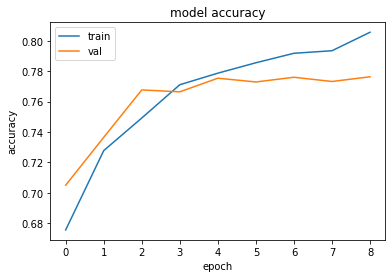

In [ ]:
plot_history(history5)

In [ ]:
model6_test = model6.predict(test_ds)
labels = np.asarray(tf.concat([y for x, y in test_ds], axis=0))
model6_conf = confusion_matrix(
        labels.argmax(axis=1),
        model6_test.argmax(axis=1)
    )
print("Accuracy: " + str(round((print_acc(model6_conf))*100,2)) + "%")
print("Error: " + str(round((1-print_acc(model6_conf))*100,2)) + "%")
pd.DataFrame(
    model6_conf,
    index = ["Neutral", "Positive", "Negative"],
    columns = ["Neutral", "Positive", "Negative"]
)

Accuracy: 78.87%
Error: 21.13%


,Neutral,Positive,Negative
Neutral,2840,195,50
Positive,411,513,60
Negative,212,93,458


In [ ]:
print(classification_report(labels.argmax(axis=1),
                            model6_test.argmax(axis=1),
                            target_names=["Neutral", "Positive", "Negative"]))

              precision    recall  f1-score   support

     Neutral       0.82      0.92      0.87      3085
    Positive       0.64      0.52      0.57       984
    Negative       0.81      0.60      0.69       763

    accuracy                           0.79      4832
   macro avg       0.76      0.68      0.71      4832
weighted avg       0.78      0.79      0.78      4832



### **Rationale:**
As we can see in the above metrics, we were unable to improve the best of the previous models that used the 'Mean' as summary operation to summarize all word vectors into one single vector to make predictions about the most likely class by the Dense Layer.

**The main reason might be because we added a huge number of weights to the classification problem, having still the same data to estimate them through the training of the Neural Network**. More precisely, we added an additional vector with the same size of the embedding dimension in the Recurrent Neural Network that had to be trained each time with the input word vectors that comprise each sentence *(that is, using the 'Context Vector', which had to be trained as well)*, and yielding as output the 'Context Vector' with the summarized information of each 20-words tweet that was used to predict the most likely class.

Consequently, **we introduced a few changes to the previous Neural Network**, besides replacing the 'Mean' as summary operation by a **RNN Layer** with an output vector of the same size of the Word Embeddings Table. All such changes were made in order to outweigh such increased number of weights to estimate, which are the following ones:

*   **We set at '70', instead of '100', the embedding dimension of the word vectors from the Word Embeddings Table**, so that the number of weights to estimate by the Neural Network decreases sufficiently to become feasible to estimate them given the available data, without at the same time simplifying too much the representation of the words in vectors and, therefore, the complexity in terms of dataset that the Neural Network is able to tackle and make predictions from.

*   **We increased the Dropout Rate up to '0.85'** in order to introduce more variety in the word vectors and sentences we provided to the RNN, thereby making more difficult by the Neural Network to fit the data.

*   **We increased the number of 'epochs' to train the Neural Network up to '9'**, since we are hindering the fitting of the data and, therefore, the Neural Network is going to require more epochs to fit at least most of the Regular Structure and generalize better *(hence, the constant increase in the 'Val_Accuracy')*.

*   **We defined a smaller batch size ('20')**, since it is known as an 'indirect or implicit regularization', as we are not providing to the Neural Networks too many observations (sentences or tweets, in our case) before it computes the Back-Propagation algorithm, thereby making the learning process of the Neural Network more imprecise to get to the minimum of the Loss Function and, consequently, it tends to generalize better.

However, even with all these changes and the aforementioned rationale, we were unable to outperform the best model with the 'Mean' as summary vector, as stated above. This is likely because having not sufficient data to train the Neural Network resulted in the previous changes that, especially the reduction of the embedding dimension, eventually led to a simpler Neural Network that was not able to capture all the intricacies and complexity of the data but, at the same time, we could not make it more complex given the data limitation we had.

**Overall though, Recurrent Neural Networks tend to work best in these settings**, since they entail a natural way *(or a 'Neural Network way')* to summarize different vectors of data, which in Text Analytics represent words from the Word Embeddings Table, into one single vector to make predictions from, instead of choosing an arbitrary way *(the Mean, the maximum value, etc)* to summarize those word vectors to provide a single vector representing a sentence to make predictions from.

In this regard, with such increased data we could even increase the vocabulary size, which we limited at 2000 words, as well as making the most of the Recurrent Neural Network to provide more reliable classifications. Nevertheless, this practice resulted in a useful introduction to Text Analytics through Neural Networks and how different approaches might be mixed to achieve more accurate predictions.
